# R5 - Neural Network and CNN for Wildfire Dataset

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier



2024-11-22 03:47:58.159914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As most of the code is same, only parameters or architecture is changed. So we have commented first experiment fully and for others commented any new section.

In [5]:
#dataset path
data = '/Users/ali/Desktop/jjjj/group-coursework-bots-ahead/data/wildifire2.csv'


 Loading Data and Preprocessing

In [7]:
# Load the dataset
data = 'wildifire2.csv'  
df = pd.read_csv(data)

# using label encoder to encode target variable (NWCG_CAUSE_CLASSIFICATION)
label_encoder = LabelEncoder()
df['NWCG_cause_encoded'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

# Encode categorical features (FIRE_DAY, FIRE_MONTH, STATE)
cat_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Drop unnecessary columns
X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_cause_encoded'])
y = to_categorical(df['NWCG_cause_encoded'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Neural Network Architecture



-  **Input Layer:** A Dense layer with 64 neurons and ReLU activation.
-  **Dropout Layers:** Two Dropout(0.3) layers to reduce overfitting.
-  **Hidden Layer:** A Dense layer with 32 neurons and ReLU activation.
-  **Output Layer:** A Dense layer with 1 neuron.
- **Loss:** binary cross_entropy
- **Optimizer:** Adam



Model training

Epoch 1/50
18735/18735 [==============================] - 33s 2ms/step - loss: 0.2708 - accuracy: 0.8860 - val_loss: 0.2550 - val_accuracy: 0.8941
Epoch 2/50
18735/18735 [==============================] - 31s 2ms/step - loss: 0.2558 - accuracy: 0.8943 - val_loss: 0.2488 - val_accuracy: 0.8981
Epoch 3/50
18735/18735 [==============================] - 31s 2ms/step - loss: 0.2525 - accuracy: 0.8960 - val_loss: 0.2467 - val_accuracy: 0.8974
Epoch 4/50
18735/18735 [==============================] - 30s 2ms/step - loss: 0.2499 - accuracy: 0.8976 - val_loss: 0.2443 - val_accuracy: 0.9007
Epoch 5/50
18735/18735 [==============================] - 30s 2ms/step - loss: 0.2484 - accuracy: 0.8981 - val_loss: 0.2465 - val_accuracy: 0.8988
Epoch 6/50
18735/18735 [==============================] - 30s 2ms/step - loss: 0.2472 - accuracy: 0.8992 - val_loss: 0.2426 - val_accuracy: 0.9010
Epoch 7/50
18735/18735 [==============================] - 30s 2ms/step - loss: 0.2462 - accuracy: 0.8997 - val_loss: 0

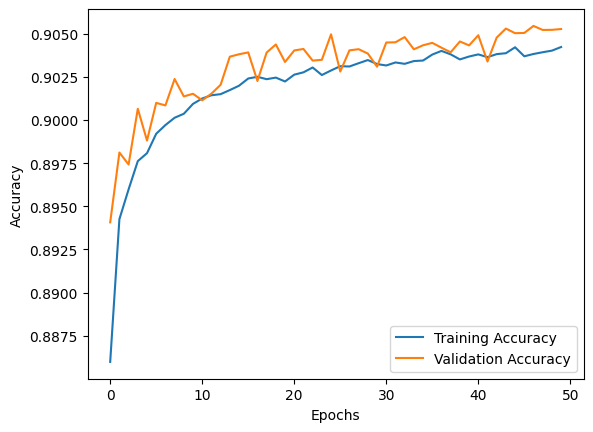

In [66]:
# Split the df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
training_model = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")




5855/5855 [==============================] - 8s 1ms/step

Classification Report:
              precision    recall  f1-score   support

       Human       0.94      0.95      0.95    156247
     Natural       0.75      0.70      0.72     31097

    accuracy                           0.91    187344
   macro avg       0.84      0.82      0.83    187344
weighted avg       0.91      0.91      0.91    187344


Confusion Matrix:
[[148920   7327]
 [  9447  21650]]


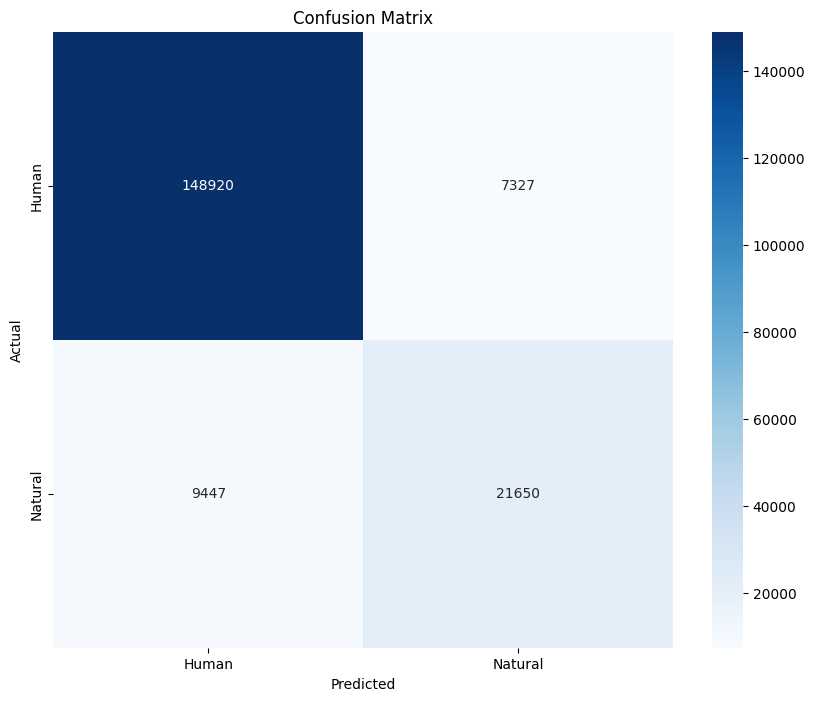

In [85]:

# Predict on the test set
Y_predict = model.predict(X_test)
y_pred_classes = np.argmax(Y_predict, axis=1)  
y_test_classes = np.argmax(y_test, axis=1)  

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

#plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




As we can see we have achieved accuracy of around 90 percent but from the confusion matrix we can see the classes are highly imbalanced. Natural cause has low precision,recall and f1-score.
One way to solve this problem is to oversample the miniority class. Instead of duplicating examples from minority class in training detaset we can sythesize examples using a technique called **SMOTE**.

loading and preprocessing data


In [ ]:
# Load the dataset
df = pd.read_csv(data)

# Encode NWCG_CAUSE_CLASSIFICATION[target var]
label_encoder = LabelEncoder()
df['NWCG_cause_encoded'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

# Encode categorical features
cat_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Drop unnecessary columns
X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_cause_encoded'])
y = df['NWCG_cause_encoded']  # Keep as scalar labels (0 or 1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)


In [ ]:
# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

#Neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
training_model = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50
31227/31227 [==============================] - 53s 2ms/step - loss: 0.3761 - accuracy: 0.8400 - val_loss: 0.3522 - val_accuracy: 0.8479
Epoch 2/50
31227/31227 [==============================] - 51s 2ms/step - loss: 0.3594 - accuracy: 0.8471 - val_loss: 0.3427 - val_accuracy: 0.8522
Epoch 3/50
31227/31227 [==============================] - 52s 2ms/step - loss: 0.3544 - accuracy: 0.8501 - val_loss: 0.3391 - val_accuracy: 0.8548
Epoch 4/50
31227/31227 [==============================] - 51s 2ms/step - loss: 0.3512 - accuracy: 0.8519 - val_loss: 0.3370 - val_accuracy: 0.8559
Epoch 5/50
31227/31227 [==============================] - 51s 2ms/step - loss: 0.3488 - accuracy: 0.8531 - val_loss: 0.3361 - val_accuracy: 0.8550
Epoch 6/50
31227/31227 [==============================] - 51s 2ms/step - loss: 0.3475 - accuracy: 0.8540 - val_loss: 0.3342 - val_accuracy: 0.8571
Epoch 7/50
31227/31227 [==============================] - 51s 2ms/step - loss: 0.3464 - accuracy: 0.8547 - val_loss: 0

9759/9759 [==============================] - 9s 935us/step
Accuracy: 0.87
Precision: 0.87
Recall: 0.86
F1 Score: 0.87

Classification Report:
              precision    recall  f1-score   support

       Human       0.86      0.87      0.87    155900
     Natural       0.87      0.86      0.87    156367

    accuracy                           0.87    312267
   macro avg       0.87      0.87      0.87    312267
weighted avg       0.87      0.87      0.87    312267



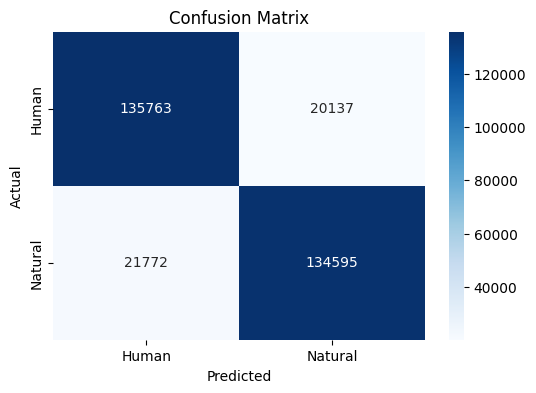

In [12]:
target_prob = model.predict(X_test)

Y_predict = (target_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, Y_predict)
precision = precision_score(y_test, Y_predict)
recall = recall_score(y_test, Y_predict)
f1 = f1_score(y_test, Y_predict)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, Y_predict, target_names=label_encoder.classes_))

# show confusion matrix
conf_matrix = confusion_matrix(y_test, Y_predict)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**After applying smoke we can see overall accuracy declined but  now as classes are balanced overall result is better.**

## Increasing hidden layers for NN


- Used Smote for solving class imabalance.
NN architecture:

- Input Layer:
- - 128 neurons
- - Batch normalizetion
- - Dropout 30 percent
- - ReLU activation

- Hidden layers increased to 6:
- - 64 neurons
- - Batch normalizetion
- - Dropout 30 percent
- - ReLU activation

Loading and Preprocessing data

In [ ]:
df = pd.read_csv(data)
label_encoder = LabelEncoder()
df['Encoded_NWCG_Cause'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])
# One-hot encode categorical features
cat_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'Encoded_NWCG_Cause'])
y = df['Encoded_NWCG_Cause']  

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)


Training model

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Neural Network model
model = Sequential()

# Input Layer
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 6 Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))



# Output Layer
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_model = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Epoch 1/50
31227/31227 [==============================] - 98s 3ms/step - loss: 0.4015 - accuracy: 0.8260 - val_loss: 0.3537 - val_accuracy: 0.8472
Epoch 2/50
31227/31227 [==============================] - 104s 3ms/step - loss: 0.3760 - accuracy: 0.8409 - val_loss: 0.3501 - val_accuracy: 0.8498
Epoch 3/50
31227/31227 [==============================] - 124s 4ms/step - loss: 0.3709 - accuracy: 0.8441 - val_loss: 0.3465 - val_accuracy: 0.8514
Epoch 4/50
31227/31227 [==============================] - 112s 4ms/step - loss: 0.3660 - accuracy: 0.8462 - val_loss: 0.3417 - val_accuracy: 0.8523
Epoch 5/50
31227/31227 [==============================] - 105s 3ms/step - loss: 0.3633 - accuracy: 0.8474 - val_loss: 0.3924 - val_accuracy: 0.8469
Epoch 6/50
31227/31227 [==============================] - 100s 3ms/step - loss: 0.3607 - accuracy: 0.8487 - val_loss: 0.3539 - val_accuracy: 0.8542
Epoch 7/50
31227/31227 [==============================] - 97s 3ms/step - loss: 0.3589 - accuracy: 0.8500 - val_lo

9759/9759 [==============================] - 9s 939us/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.86      0.87    155900
     Class 1       0.86      0.87      0.87    156367

    accuracy                           0.87    312267
   macro avg       0.87      0.87      0.87    312267
weighted avg       0.87      0.87      0.87    312267



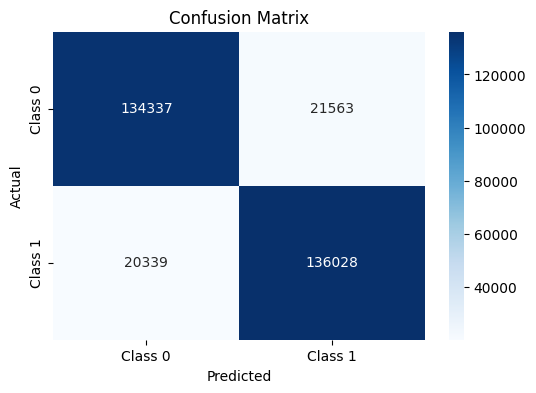

In [18]:
target_prob = model.predict(X_test) 
Y_predict = (target_prob > 0.5).astype(int) 
print("\nClassification Report:")
print(classification_report(y_test, Y_predict, target_names=['Class 0', 'Class 1']))

#  Confusion Matrix 
conf_matrix = confusion_matrix(y_test, Y_predict)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()





Changing hyperparameters
- Neurons in Hidden layer reduced to 32
- Dropout 0.2
- Epochs increased to 70

Loading and Preprocessing the Dataset 

In [28]:
df = pd.read_csv(data)

label_encoder = LabelEncoder()
df['NWCG_cause_encoded'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

cat_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_cause_encoded'])
y = df['NWCG_cause_encoded']  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

#Neural network model
model = Sequential()

# Input Layer
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#hidden layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#output layer
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
training_model = model.fit(X_train, y_train, epochs=70, batch_size=64, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/70
15614/15614 [==============================] - 55s 3ms/step - loss: 0.4081 - accuracy: 0.8215 - val_loss: 0.3547 - val_accuracy: 0.8496
Epoch 2/70
15614/15614 [==============================] - 45s 3ms/step - loss: 0.3696 - accuracy: 0.8428 - val_loss: 0.3452 - val_accuracy: 0.8522
Epoch 3/70
15614/15614 [==============================] - 47s 3ms/step - loss: 0.3624 - accuracy: 0.8461 - val_loss: 0.3417 - val_accuracy: 0.8541
Epoch 4/70
15614/15614 [==============================] - 49s 3ms/step - loss: 0.3576 - accuracy: 0.8484 - val_loss: 0.3348 - val_accuracy: 0.8581
Epoch 5/70
15614/15614 [==============================] - 51s 3ms/step - loss: 0.3536 - accuracy: 0.8510 - val_loss: 0.3340 - val_accuracy: 0.8586
Epoch 6/70
15614/15614 [==============================] - 51s 3ms/step - loss: 0.3510 - accuracy: 0.8523 - val_loss: 0.3319 - val_accuracy: 0.8601
Epoch 7/70
15614/15614 [==============================] - 51s 3ms/step - loss: 0.3491 - accuracy: 0.8531 - val_loss: 0

Performance Matrices

9759/9759 [==============================] - 8s 793us/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.86      0.87    156134
     Class 1       0.86      0.87      0.87    156133

    accuracy                           0.87    312267
   macro avg       0.87      0.87      0.87    312267
weighted avg       0.87      0.87      0.87    312267


Confusion Matrix:
[[134825  21309]
 [ 20012 136121]]


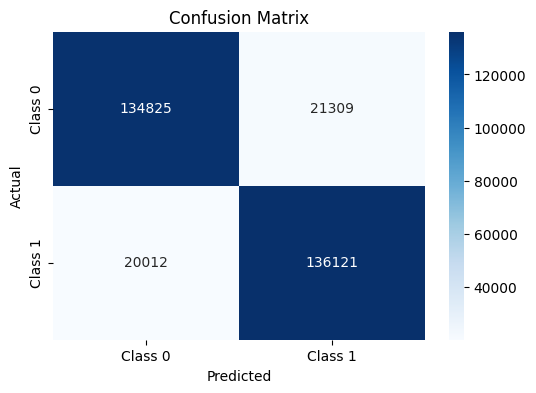

In [30]:

target_prob = model.predict(X_test)
Y_predict = (target_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, Y_predict, target_names=["Class 0", "Class 1"]))

#Confusion Matrix 
conf_matrix = confusion_matrix(y_test, Y_predict)
print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



## CNN Implementation

As we have tabular data and CNN requires 2D data we first preprocess the data by dropping unnecessary columns, encoding categorical features, normalizing features,padding and resphape to 2D to pass the data into CNN

### Model Architecture

Input layer:
- Conv2D(16, (2, 2)): A 2D convolutional layer with 16 filters of size 2x2
- Activation function: ReLU
- Input Shape: (row,col,channel)

BatchNormalization: for normalization of input

MaxPooling2D:  Reduces the spatial dimensions of the feature maps
-Pool_size=(2, 1): reduces height by 1/2 and width unchanged.

Dropout: 20 percent

Second Convolutional Layer Conv2D: for extracting deeper patterns and features from input
- Conv2D(32, (2, 2)): 32 filters to capture complex features and filter size 2x2
- Activation function: ReLU

MaxPooling2D (pool_size=(2, 1)): removes negative dimensions

GlobalMaxPooling2D(): Reduces dimensions safely

Fully Connected (Dense) Layer:
- 64 Neurons
- ReLU activation function

Dropout(0.3)

Output Layer: Dense(1, activation='sigmoid')
- 1 Neuron (human or natural)
- Sigmoid activation

Loading and Preprocessing

In [6]:
df = pd.read_csv(data)
df = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE'])

categorical_columns = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

target_encoder = LabelEncoder()
df['NWCG_CAUSE_CLASSIFICATION'] = target_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

X = df.drop(columns=['NWCG_CAUSE_CLASSIFICATION'])
y = df['NWCG_CAUSE_CLASSIFICATION']

numerical_columns = ['Fire_Duration', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']
scaler = MinMaxScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Add 0 column padding to make features even
if X.shape[1] % 2 != 0:
    X['PADDING'] = 0 

# SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# reshaping dimensions
num_features = X_balanced.shape[1]
reshaped_dim1 = num_features // 2
reshaped_dim2 = 2

# Reshape the data to 2D for CNN
X_balanced_reshaped = X_balanced.values.reshape(X_balanced.shape[0], reshaped_dim1, reshaped_dim2, 1)


Training model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_reshaped, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)
# CNN Model
model = Sequential([
    #1 convolution layer
    Conv2D(16, (2, 2), activation='relu', input_shape=(reshaped_dim1, reshaped_dim2, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1), padding='same'), 
    Dropout(0.3),
    
    #2 convolution layer
    Conv2D(32, (2, 2), activation='relu', padding='same'), 
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1), padding='same'),  
    Dropout(0.3),
    GlobalAveragePooling2D(),  
    
    #output layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
training_model = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Epoch 1/50


2024-11-22 03:49:16.542781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


15614/15614 [==============================] - 34s 2ms/step - loss: 0.5570 - accuracy: 0.7218 - val_loss: 0.4413 - val_accuracy: 0.8047
Epoch 2/50
15614/15614 [==============================] - 34s 2ms/step - loss: 0.4741 - accuracy: 0.7932 - val_loss: 0.4180 - val_accuracy: 0.8220
Epoch 3/50
15614/15614 [==============================] - 32s 2ms/step - loss: 0.4661 - accuracy: 0.7970 - val_loss: 0.4169 - val_accuracy: 0.8245
Epoch 4/50
15614/15614 [==============================] - 34s 2ms/step - loss: 0.4615 - accuracy: 0.7995 - val_loss: 0.4168 - val_accuracy: 0.8256
Epoch 5/50
15614/15614 [==============================] - 35s 2ms/step - loss: 0.4695 - accuracy: 0.7941 - val_loss: 0.4262 - val_accuracy: 0.8175
Epoch 6/50
15614/15614 [==============================] - 34s 2ms/step - loss: 0.4643 - accuracy: 0.7965 - val_loss: 0.4218 - val_accuracy: 0.8195
Epoch 7/50
15614/15614 [==============================] - 39s 2ms/step - loss: 0.4635 - accuracy: 0.7971 - val_loss: 0.4224 - val

9759/9759 [==============================] - 8s 770us/step


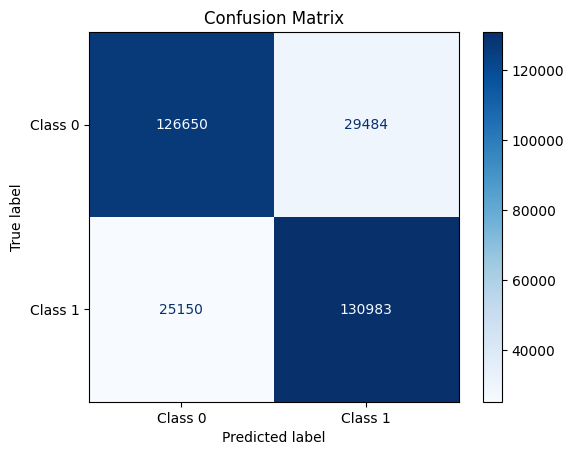

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    156134
           1       0.82      0.84      0.83    156133

    accuracy                           0.83    312267
   macro avg       0.83      0.83      0.83    312267
weighted avg       0.83      0.83      0.83    312267



In [9]:
target_prob = model.predict(X_test)
Y_predict = (target_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, Y_predict, target_names=["Class 0", "Class 1"]))

#Confusion Matrix 
conf_matrix = confusion_matrix(y_test, Y_predict)
print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Load and Preprocess Data

In [ ]:
df = pd.read_csv(data)
label_encoder = LabelEncoder()
df['Encoded_NWCG_Cause'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

categorical_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'Encoded_NWCG_Cause'])
y = np.array(df['Encoded_NWCG_Cause'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
# find reshaped dimensions for CNN
num_features = X_train.shape[1]

# Add 0 column padding to make features even
if num_features % 2 != 0:
    X_train = np.pad(X_train, ((0, 0), (0, 1)), mode='constant')
    X_test = np.pad(X_test, ((0, 0), (0, 1)), mode='constant')
    num_features += 1

# Calculate reshaping dimensions
reshaped_dim1 = num_features // 2
reshaped_dim2 = 2

# Reshape the feature matrices
Xtrain_reshaped = X_train.reshape(X_train.shape[0], reshaped_dim1, reshaped_dim2, 1)
Xtest_reshaped = X_test.reshape(X_test.shape[0], reshaped_dim1, reshaped_dim2, 1)

print(f"X_train reshaped to: {Xtrain_reshaped.shape}")
print(f"X_test reshaped to: {Xtest_reshaped.shape}")

#  reshaped dimensions for CNN
num_features = X_train.shape[1]
reshaped_dim1 = num_features // 2
reshaped_dim2 = 2
Xtrain_reshaped = X_train.reshape(X_train.shape[0], reshaped_dim1, reshaped_dim2, 1)
Xtest_reshaped = X_test.reshape(X_test.shape[0], reshaped_dim1, reshaped_dim2, 1)


Training model

In [2]:
# CNN model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(reshaped_dim1, reshaped_dim2, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Conv2D(32, (1, 1), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
training_model = model.fit(Xtrain_reshaped, y_train,epochs=50,batch_size=64,validation_split=0.2,verbose=1)
test_loss, test_accuracy = model.evaluate(Xtest_reshaped, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")




X_train reshaped to: (1249067, 36, 2, 1)
X_test reshaped to: (312267, 36, 2, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 2, 128)        1280      
                                                                 
 batch_normalization (BatchN  (None, 36, 2, 128)       512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 1, 128)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 1, 128)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 1, 64)         73792     
                                          

2024-11-17 20:04:07.652252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
15614/15614 [==============================] - 416s 27ms/step - loss: 0.3883 - accuracy: 0.8355 - val_loss: 0.3479 - val_accuracy: 0.8527
Epoch 2/50
15614/15614 [==============================] - 350s 22ms/step - loss: 0.3656 - accuracy: 0.8463 - val_loss: 0.3456 - val_accuracy: 0.8545
Epoch 3/50
15614/15614 [==============================] - 346s 22ms/step - loss: 0.3603 - accuracy: 0.8489 - val_loss: 0.3401 - val_accuracy: 0.8558
Epoch 4/50
15614/15614 [==============================] - 435s 28ms/step - loss: 0.3571 - accuracy: 0.8501 - val_loss: 0.3373 - val_accuracy: 0.8566
Epoch 5/50
15614/15614 [==============================] - 393s 25ms/step - loss: 0.3547 - accuracy: 0.8511 - val_loss: 0.3349 - val_accuracy: 0.8583
Epoch 6/50
15614/15614 [==============================] - 395s 25ms/step - loss: 0.3524 - accuracy: 0.8519 - val_loss: 0.3343 - val_accuracy: 0.8591
Epoch 7/50
15614/15614 [==============================] - 434s 28ms/step - loss: 0.3508 - accuracy: 0.8522

Performance Metrics

9759/9759 [==============================] - 39s 4ms/step
Accuracy: 0.87
Precision: 0.87
Recall: 0.86
F1 Score: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87    156134
           1       0.87      0.86      0.86    156133

    accuracy                           0.87    312267
   macro avg       0.87      0.87      0.87    312267
weighted avg       0.87      0.87      0.87    312267



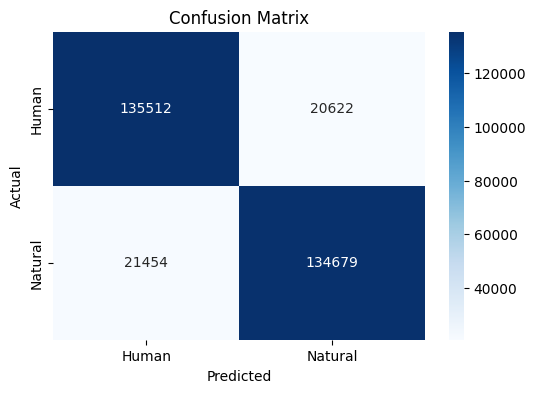

In [4]:
target_prob = model.predict(Xtest_reshaped)
Y_predict = (target_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, Y_predict)
precision = precision_score(y_test, Y_predict)
recall = recall_score(y_test, Y_predict)
f1 = f1_score(y_test, Y_predict)
conf_matrix = confusion_matrix(y_test, Y_predict)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, Y_predict))

#confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "Natural"], yticklabels=["Human", "Natural"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Catboost

**Applying Catboost to see if model accuracy changes or not. Catboost is specifically designed for categorical data so we believe it will  perform better than CNN and ANN.**

Preprocessing

In [ ]:
df = pd.read_csv(data)

label_encoder = LabelEncoder()
df['Encoded_NWCG_Cause'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

cat_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)
X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'Encoded_NWCG_Cause'])
y = df['Encoded_NWCG_Cause']  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

training model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, use_best_model=True)
Y_predict = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, Y_predict)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



0:	learn: 0.8268468	test: 0.8280702	best: 0.8280702 (0)	total: 223ms	remaining: 22s
99:	learn: 0.8808711	test: 0.8818575	best: 0.8818575 (99)	total: 12.6s	remaining: 0us

bestTest = 0.881857513
bestIteration = 99

Test Accuracy: 88.19%


Performance Metrics


Classification Report:
              precision    recall  f1-score   support

       Human       0.88      0.89      0.88    155900
     Natural       0.89      0.88      0.88    156367

    accuracy                           0.88    312267
   macro avg       0.88      0.88      0.88    312267
weighted avg       0.88      0.88      0.88    312267



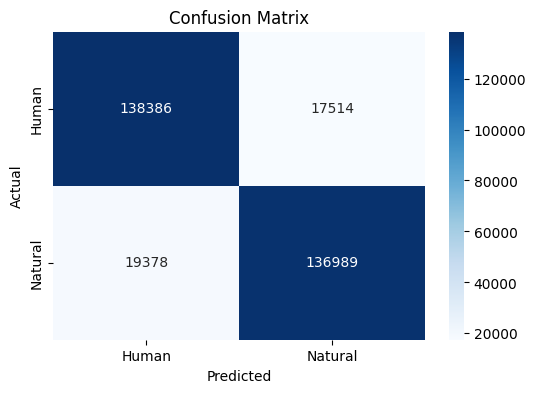

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, Y_predict, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, Y_predict)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
df = pd.read_csv(data)

label_encoder = LabelEncoder()
df['Encoded_NWCG_Cause'] = label_encoder.fit_transform(df['NWCG_CAUSE_CLASSIFICATION'])

cat_features = ['FIRE_DAY', 'FIRE_MONTH', 'STATE']
df = pd.get_dummies(df, columns=cat_features, drop_first=True)
X = df.drop(columns=['Unnamed: 0', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_CLASSIFICATION', 'Encoded_NWCG_Cause'])
y = df['Encoded_NWCG_Cause']  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=20,
    random_seed=42
)

catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, use_best_model=True)
Y_predict = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, Y_predict)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



0:	learn: 0.8268468	test: 0.8280702	best: 0.8280702 (0)	total: 122ms	remaining: 36.5s
20:	learn: 0.8565009	test: 0.8576250	best: 0.8576250 (20)	total: 2.23s	remaining: 29.7s
40:	learn: 0.8668558	test: 0.8676229	best: 0.8676229 (40)	total: 4.16s	remaining: 26.3s
60:	learn: 0.8728987	test: 0.8736402	best: 0.8736402 (60)	total: 6.21s	remaining: 24.3s
80:	learn: 0.8772500	test: 0.8781075	best: 0.8781075 (80)	total: 8.19s	remaining: 22.1s
100:	learn: 0.8810408	test: 0.8820721	best: 0.8820721 (100)	total: 10.2s	remaining: 20.2s
120:	learn: 0.8837076	test: 0.8846852	best: 0.8846852 (120)	total: 12.2s	remaining: 18s
140:	learn: 0.8861750	test: 0.8872119	best: 0.8872119 (140)	total: 14.1s	remaining: 15.9s
160:	learn: 0.8884960	test: 0.8897610	best: 0.8897610 (160)	total: 16.1s	remaining: 13.9s
180:	learn: 0.8903670	test: 0.8917689	best: 0.8917689 (180)	total: 18.1s	remaining: 11.9s
200:	learn: 0.8922123	test: 0.8936199	best: 0.8936199 (200)	total: 20.2s	remaining: 9.95s
220:	learn: 0.8937431	te


Classification Report:
              precision    recall  f1-score   support

       Human       0.90      0.90      0.90    155900
     Natural       0.90      0.90      0.90    156367

    accuracy                           0.90    312267
   macro avg       0.90      0.90      0.90    312267
weighted avg       0.90      0.90      0.90    312267



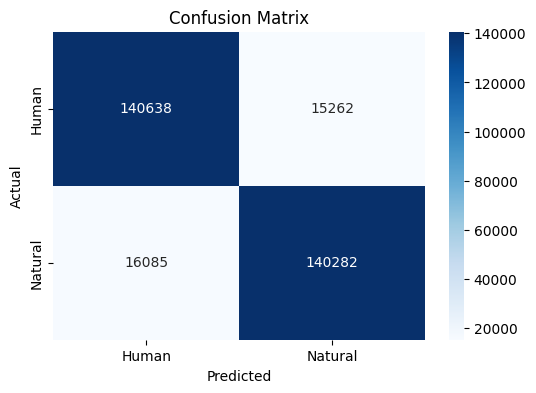

In [14]:
print("\nClassification Report:")
print(classification_report(y_test, Y_predict, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, Y_predict)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Summary of Results


- You should always shows performance metrics other than accuracy as it can help point out important things. For example when we applied simple neural network the accuracy was high around 90 percent but this was due to the fact that the classes were imbalanced i.e one had around 140000 sample and other had around 20000.

- Neural network when applied after applying SMOTE for balancing data gave overall better performance.Overall accuracy was reduced to 86.58% but recall and precision improved for miniority class.
- We experemented Neural network with different number of layers but there was no significant improvement and same for hyperparameters changing epoch,droput or input size didn;t have any affect.

- CNN was implemented but as we have tabular data we didn't expect it to perform better.
- Simple CNN with 2Conv layer gave accuracy of 83 percent which was below ANN. But when we increased 2CONV layers to 3 and changed dropout and input,output neurons we got accuracy around 86.5%.

- Catboost performed best because of its ability to deal with categorical data.
- Catboost acheived test and train accuracy of 88 percent and it was computationally cheap because it took less time to train.

